### Ejercicio de Topic Modelling
* Conjunto de datos: Resúmenes médicos.

##### Preparación

In [ ]:
!pip install pyLDAvis
!pip install bertopic
!pip install bertopic[visualization]

In [1]:
# Importar librerías de análisis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Ignorar advertencias
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Definir un tema para graficar
sns.set_style('whitegrid')

In [3]:
# Definir lista de colores
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

In [4]:
# Importar librerías de manejo de texto
import re
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [6]:
# Descargar complementos de NLTK
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
# Iniciar instancias de stopwords y lematizador 
stop_words = set(stopwords.words('english'))
st = PorterStemmer()

In [8]:
# Crear función de limpieza del texto
def limpiar_texto(df, col, clean_col):

    # Convertir en minúsculas y eliminar espacios en ambos lados
    df[clean_col] = df[col].apply(lambda x: x.lower().strip())

    # Eliminar espacios extra dentro del texto
    df[clean_col] = df[clean_col].apply(lambda x: re.sub(' +', ' ', x))

    # Eliminar puntuación
    df[clean_col] = df[clean_col].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))

    # Eliminar stopwords y obtener la raíz
    df[clean_col] = df[clean_col].apply(lambda x: ' '.join(st.stem(text) for text in x.split() if text not in stop_words and len(text) > 2))

    return df

##### Preprocesamiento

In [9]:
# Abrir el archivo
df = pd.read_csv('MedicalAbstracts_CardiovascularDiseases.csv', header=0, sep=',')
df.shape

(13924, 2)

In [10]:
# Ver las primeras filas
df.head()

,Unnamed: 0,doc
0,0,Improved outcome at 28 days of age for very l...
1,1,Chylothorax after posterior spinal instrument...
2,2,Childhood pulmonary function following hyalin...
3,3,Treatment of atelectasis of upper lung lobes....
4,4,"Decision analysis, public health policy, and ..."


In [11]:
# Eliminar la columna 'Unnamed: 0'
df.drop('Unnamed: 0', axis=1, inplace=True)

In [12]:
# Ver la información del conjunto de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13924 entries, 0 to 13923
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   doc     13924 non-null  object
dtypes: object(1)
memory usage: 108.9+ KB


In [13]:
# Aplicar el preprocesamiento de texto
limpiar_texto(df, 'doc', 'Abstract')
df['Length'] = df['Abstract'].str.len()
df.head()

,doc,Abstract,Length
0,Improved outcome at 28 days of age for very l...,improv outcom day age low birth weight infant ...,1236
1,Chylothorax after posterior spinal instrument...,chylothorax posterior spinal instrument fusion...,247
2,Childhood pulmonary function following hyalin...,childhood pulmonari function follow hyalin mem...,558
3,Treatment of atelectasis of upper lung lobes....,treatment atelectasi upper lung lobe select br...,561
4,"Decision analysis, public health policy, and ...",decis analysi public health polici isoniazid c...,957


In [14]:
# Inspeccionar la longitud
df['Length'].describe()

count    13924.000000
mean       770.448291
std        309.326547
min        103.000000
25%        545.000000
50%        755.000000
75%        975.000000
max       2655.000000
Name: Length, dtype: float64

In [15]:
# Vectorizar el texto con BoW
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=10, max_df=0.1, ngram_range=(1,2))
BOW = vectorizer.fit_transform(df['Abstract'])
BOW.shape

(13924, 18381)

In [16]:
# Inspeccionar la longitud del vocabulario
vocab = vectorizer.get_feature_names()
len(vocab)

18381

##### Ajustar el modelo LDA

Ajustar modelos LDA con las librerías: `sklearn` y `BERTopic`.

In [17]:
# Entrenar el modelo
from sklearn.decomposition import LatentDirichletAllocation

lda_model = LatentDirichletAllocation(n_components=10, learning_method='online', random_state=101, max_iter=100)
lda_model.fit(BOW)

LatentDirichletAllocation(learning_method='online', max_iter=100,
                          random_state=101)

In [18]:
# Crear matriz de distribución de los resúmenes por tema
doc_top = pd.DataFrame(lda_model.transform(BOW))
df_lda = pd.merge(df, doc_top, left_index=True, right_index=True)
print(doc_top.shape)

(13924, 10)


In [20]:
# Crear matriz de frecuencia de palabras por tema
μs = pd.DataFrame(lda_model.exp_dirichlet_component_, columns=vocab)
print(μs.shape)

(10, 18381)


In [21]:
# Visualizar el modelo
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(lda_model, BOW, vectorizer)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.089633  0.198807       1        1  14.609376
9     -0.230514  0.105796       2        1  13.633630
1     -0.025912  0.108895       3        1  10.776946
0      0.211304  0.149190       4        1  10.668777
4     -0.079716 -0.262588       5        1   9.961130
6      0.289221 -0.020688       6        1   9.612056
7     -0.057200 -0.008443       7        1   9.486112
2     -0.017472  0.000289       8        1   8.503497
5     -0.030268 -0.103648       9        1   7.200324
3      0.030190 -0.167610      10        1   5.548153, topic_info=           Term         Freq        Total Category  logprob  loglift
17094     tumor  4086.000000  4086.000000  Default  30.0000  30.0000
1961     cancer  2902.000000  2902.000000  Default  29.0000  29.0000
13445       rat  2333.000000  2333.000000  Default  28.0000  28.0000
13919     renal  1970.000000  1970.000000  Default  27.0000  27.0000
869    antibodi  2153.000000  2153.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
6133      fluid   369.662180  1009.015927  Topic10  -5.3613   1.8876
17920    visual   311.030338   638.707537  Topic10  -5.5340   2.1721
11226     organ   330.181392   861.770302  Topic10  -5.4742   1.9324
17899      viru   356.437322  1348.134896  Topic10  -5.3977   1.5614
2712    chronic   375.353092  1935.291863  Topic10  -5.3460   1.2516

[589 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
19         3  0.124127        abnorm
19         4  0.004330        abnorm
19         5  0.065431        abnorm
19         6  0.013952        abnorm
19         7  0.210728        abnorm
...      ...       ...           ...
18209      5  0.037700         women
18209      8  0.256742         women
18209      9  0.006681         women
18255      7  0.996884         wound
18311      2  0.994797  year patient

[1256 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 10, 2, 1, 5, 7, 8, 3, 6, 4])

In [22]:
# Iterar diccionario con el tema y las principales palabras
words = {}
n_top_words = 100

for topic, component in enumerate(lda_model.components_):
    # Se necesita [::-1] para ordenar el arreglo de forma descendente
    indices = np.argsort(component)[::-1][:n_top_words]
    # Guardar las palabras más relevantes a cada tema
    words[topic] = [vocab[i] for i in indices]

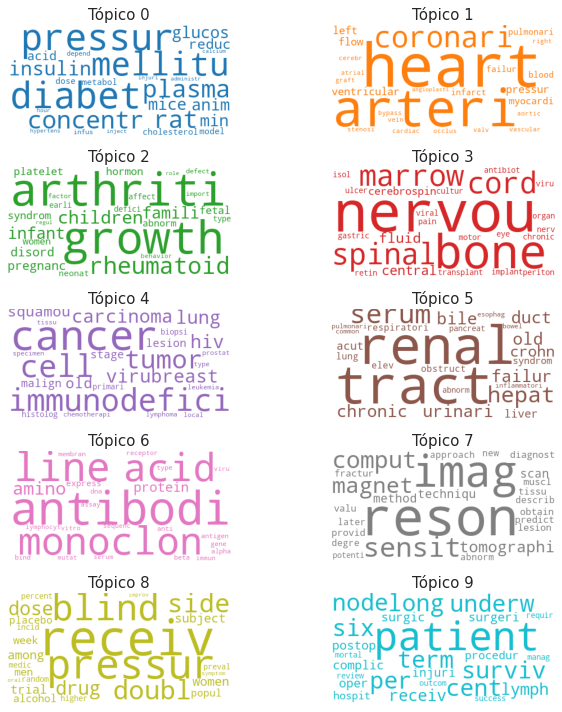

In [23]:
# Dibujar una nube de palabras por cada tema
cloud = WordCloud(background_color='white', max_words=25, prefer_horizontal=1.0, colormap='tab10', color_func=lambda *args, **kwargs: cols[i])

fig, axes = plt.subplots(5, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    text = " ".join(x for x in words[i])
    cloud.generate(text)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Tópico ' + str(i), fontdict=dict(size=15))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [25]:
# Entrenar el modelo BERTopic
from bertopic import BERTopic

docs = list(df['Abstract'])
model = BERTopic(nr_topics=10, verbose=True)
topics, probabilities = model.fit_transform(docs)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Batches:   0%|          | 0/436 [00:00<?, ?it/s]

2022-09-12 21:28:33,209 - BERTopic - Transformed documents to Embeddings
2022-09-12 21:29:20,196 - BERTopic - Reduced dimensionality
2022-09-12 21:29:20,933 - BERTopic - Clustered reduced embeddings
2022-09-12 21:29:34,607 - BERTopic - Reduced number of topics from 194 to 11


In [26]:
# Seleccionar los temas y palabras representativas
model.get_topic_freq().head(11)
model.get_topic(6)

[('asthma', 0.07470317847749673),
 ('respiratori', 0.03731670769069669),
 ('airway', 0.03620143396326546),
 ('subject', 0.03377191267682024),
 ('inhal', 0.0336292985453831),
 ('lung', 0.029838681406526603),
 ('bronchial', 0.02933919198179269),
 ('fev', 0.028723940175373924),
 ('patient', 0.028568159058607365),
 ('asthmat', 0.02840654295295944)]

In [28]:
# Graficar las principales palabras por tópico
model.visualize_barchart()

In [27]:
# Visualizar la matriz de similitud entre temas
model.visualize_heatmap()